# Mixtures of MDPs -- Actual Figures

In [1]:
# Imports 


import sys
# setting path
sys.path.append('../core')
import os
#os.environ["VECLIB_MAXIMUM_THREADS"] = "10"

from sklearn.decomposition import PCA

#bread and butter
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

#machine learning library
import sklearn
import sklearn.manifold
import sklearn.cluster
import sklearn.decomposition

#statistics
import scipy
from scipy.stats import rankdata, norm

import numba
from numba import jit, njit

from tqdm import tqdm
import copy
import cvxpy as cp

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
%matplotlib inline
#import numpy as tnp
import warnings
warnings.filterwarnings('ignore')

# import dfply
# from dfply import *
# import ray
# import datetime


import os
import warnings
warnings.filterwarnings("ignore")

#import torch
#torch.cuda.is_available()
import tensorflow as tf
print(tf.config.list_physical_devices('GPU'))

import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from tqdm import tqdm
import pandas as pd
import scipy

import confound_mdp
import confound_ope
import confound_env
import copy
import pickle

from subspace import *
from clustering import *
from emalg import *
from helpers import *


import multiprocessing

%matplotlib inline
plt.style.use('matplotlibrc')

2023-01-25 14:41:20.889263: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-01-25 14:41:20.939097: I tensorflow/core/util/port.cc:104] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-01-25 14:41:21.217414: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory
2023-01-25 14:41:21.217438: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not l

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


2023-01-25 14:41:21.522321: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-01-25 14:41:21.537342: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-01-25 14:41:21.537411: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero


In [18]:
#FLIP THIS TO TRUE IF YOU WANT TO SEE MORE PLOTS WHILE THINGS ARE RUNNING
diagnostic = False

horizons = [20, 30, 40, 50, 60, 70, 80, 90, 100]
#horizons = [100]

#BY DEFAULT SET TO 30
trials = 30



clusterAccsTrials = []
clusterAccsNoProjsTrials = []
clusterAccsRandProjsTrials = []
classAccsTrials = []
classProjAccsTrials = []
hardClustEMAccsTrials = []
softClustEMAccsTrials = []
hardClassEMAccsTrials = []
softClassEMAccsTrials = []
hardEMAccsTrials = []
softEMAccsTrials = []

for trial in range(trials):
    clusterAccs = []
    clusterAccsNoProjs = []
    clusterAccsRandProjs = []
    modelEstims = []
    classAccs = []
    classProjAccs = []
    hardClustEMs = []
    hardClustEMAccs = []
    softClustEMs = []
    softClustEMAccs = []
    softClassEMs = []
    softClassEMAccs = []
    hardClassEMs = []
    hardClassEMAccs = []
    hardEMs = []
    hardEMAccs = []
    softEMs = []
    softEMAccs = []
    
    start_seed = trial*multiprocessing.cpu_count()
    print("Trial", trial, "with start seed", start_seed)

    for horizon in horizons:
        print("Current Horizon is:", horizon)

        ###GRIDWORLD###
    
        pi_b, P, R, x_dist, u_dist, gamma = confound_env.gridworld_opetools(horizon = horizon, slip = 0.04, 
                                                                        confound_weight=0.6, small=False, soft=True)
        pi_b[0] = pi_b.mean(0)
        pi_b[1] = pi_b.mean(0)

        mdp = confound_mdp.ConfoundMDP(P, R, x_dist, u_dist, gamma)

        nStates = P.shape[2]
        nActions = P.shape[1]

        ###GRIDWORLD###

        dataset = getSamplesMultiProc(1000, mdp, pi_b, horizon, start_seed=start_seed, iid=False)

         # behavior value
        print("value of pi_b")
        returns = confound_mdp.calc_returns(dataset, gamma, horizon)
        print(returns.mean())
    

        stateactions = dataset[:, :, [0, 1]]
        memorder = 'C'

        if memorder == 'F':
            stateactions = (dataset[:,:,0] + dataset[:,:,1]*nStates).astype(int) #we code (S x A) as s + a|S|, 0,16,32,48 1,17,33,49
        else:
            stateactions = (dataset[:,:,0]*nActions + dataset[:,:,1]).astype(int)
        states = (dataset[:,:,0]).astype(int)
        actions = (dataset[:,:,1]).astype(int)
        currstates = dataset[:,:,[0,1]].astype(int)
        confounders = dataset[:,:,2].astype(int)
        labels = confounders[:,0].astype(int)
        nextstates = dataset[:,:,3].astype(int)

        L = 2
        K = 2
        #S = nStates*nActions
        #N = len(threes)


        ########SUBSPACE ESTIMATION########

        sadim = nStates*nActions
        spdim = nStates
        omegaone = np.array([i for i in range(int(horizon/4), 2*int(horizon/4))])
        omegatwo = np.array([i for i in range(3*int(horizon/4), horizon)])
        onehotsa = np.eye(sadim)[stateactions]
        #onehotsaflat = copy.deepcopy(onehotsa)
        onehotsa = onehotsa.reshape((onehotsa.shape[0], onehotsa.shape[1], nStates, nActions), order=memorder)
        onehotsp = np.eye(np.max(nextstates)+1)[nextstates]
        sz = int(onehotsa.shape[0]/3)

        eigvalsa, eigvecsa = getEig(onehotsa[:sz], onehotsp[:sz], omegaone, omegatwo, K, wt=True, smalldata=False, device='/GPU:0')

        #########CLUSTERING#########

        device = "/GPU:0"

        hs = np.array([geth(onehotsa[sz:,omegaone,:,:], 
                                         onehotsp[sz:,omegaone,:]), 
                                  geth(onehotsa[sz:,omegatwo,:,:], 
                                       onehotsp[sz:,omegatwo,:])], dtype=np.float32)

        statmns = computeStat(hs, 
                          eigvecsa, numpy=False, smalldata=False, device=device, proj=True)

        statNoProjs = computeStat(hs, 
                          eigvecsa, numpy=False, smalldata=False, device=device, proj=False)
        
        randProjs = np.linalg.qr(np.random.normal(size=(nStates,nActions,nStates,K)))[0]
        statRandProjs = computeStat(hs, 
                                    randProjs, numpy=False, smalldata=False, device=device, proj=True)
        
        if diagnostic:
            clusterDiagnostics(statmns, K=K, labels=confounders[sz:, 0],
                           lo=0, hi=0.0005, step=0.000025) #0,0.01, 0.0001
            plt.show()
            clusterDiagnostics(statNoProjs, K=K, labels=confounders[sz:, 0],
                       lo=0, hi=0.0005, step=0.000025) #0,0.01, 0.0001
            plt.show()
            clusterDiagnostics(statRandProjs, K=K, labels=confounders[sz:, 0],
                       lo=0, hi=0.0005, step=0.000025) #0,0.01, 0.0001
            plt.show()

        clusterlabs = sklearn.cluster.spectral_clustering((statmns < 0.0001).astype(int), n_clusters=2,
                                                         assign_labels='kmeans')

        clusterlabsNoProjs = sklearn.cluster.spectral_clustering((statNoProjs < 0.0001).astype(int), n_clusters=2,
                                                         assign_labels='kmeans')
        
        clusterlabsRandProjs = sklearn.cluster.spectral_clustering((statRandProjs < 0.0001).astype(int), n_clusters=2,
                                                         assign_labels='kmeans')
    
        
        
        
        permutation = np.argmax([np.mean(clusterlabs == confounders[sz:, 0]), 
                        np.mean(clusterlabs != confounders[sz:, 0])])
        if diagnostic:
            print(permutation, np.max([np.mean(clusterlabs == confounders[sz:, 0]), 
                        np.mean(clusterlabs != confounders[sz:, 0])]))
        clusterAccs.append(np.max([np.mean(clusterlabs == confounders[sz:, 0]), 
                        np.mean(clusterlabs != confounders[sz:, 0])]))

        clusterAccsNoProjs.append(np.max([np.mean(clusterlabsNoProjs == confounders[sz:, 0]), 
                        np.mean(clusterlabsNoProjs != confounders[sz:, 0])]))
        
        clusterAccsRandProjs.append(np.max([np.mean(clusterlabsRandProjs == confounders[sz:, 0]), 
                        np.mean(clusterlabsRandProjs != confounders[sz:, 0])]))

        ########MODEL ESTIMATION#########
        Phat_ksa = getModelEstim(clusterlabs.astype(int), 
                             states[sz:,:], 
                             actions[sz:,:], 
                             nextstates[sz:,:],
                            K=K, nStates=nStates, nActions=nActions, hard=True)
        modelEstims.append(Phat_ksa)


        ########CLASSIFICATION#########
        priorclass = np.bincount(clusterlabs)/len(clusterlabs) 
        piclust = getPolicyEstim(states[sz:], actions[sz:], 
                                 K, nStates, nActions, preds=clusterlabs, hard=True)
        startweights = getStartWeights(states[sz:], clusterlabs, K, nStates)
        subspaceClass = classify(Phat_ksa, states[:sz,:], actions[:sz,:], 
                               nextstates[:sz,:], piclust, reg=1, 
                           prior=priorclass, startweights = startweights, labs=True)
        if diagnostic:
            print('Subspace Classification accuracy:', [np.mean(labels[:sz] == subspaceClass), 
                                                    np.mean(labels[:sz] != subspaceClass)][permutation])
        classAccs.append(np.max([np.mean(labels[:sz] == subspaceClass), np.mean(labels[:sz] != subspaceClass)]))
        
        hsubs = np.array([geth(onehotsa[:sz,omegaone,:,:], 
                                         onehotsp[:sz,omegaone,:]), 
                                  geth(onehotsa[:sz,omegatwo,:,:], 
                                       onehotsp[:sz,omegatwo,:])], 
                 dtype=np.float32)
        projclass = classifyProj(dataset[sz:], clusterlabs, hsubs, Phat_ksa, K, nStates, nActions)
        classProjAccs.append(np.max([np.mean(labels[:sz] == projclass), np.mean(labels[:sz] != projclass)]))


        ########EM ALGORITHM########
        priorclass = np.bincount(clusterlabs)/len(clusterlabs) 
        piclust = getPolicyEstim(states[sz:], actions[sz:], 
                                 K, nStates, nActions, preds=clusterlabs, hard=True)

        startweights = getStartWeights(states[sz:], clusterlabs, K, nStates)
        maxapos = classify(Phat_ksa, states, actions, 
                               nextstates, piclust, reg=1, 
                           prior=priorclass, startweights = startweights, labs=True)
        mleprobs = classify(Phat_ksa, states, actions, 
                               nextstates, piclust, reg=1, 
                            prior=priorclass, startweights = startweights, labs=False)
        if diagnostic:
            print('MAP estimate overall accuracy:', 
                  [np.mean(labels == maxapos), np.mean(labels != maxapos)][permutation])

        # HARD EM 
        expectclass, modelestimclass, loglikclass = em(maxapos, 
                                Phat_ksa, states, actions, 
                            nextstates, labels=labels, 
                            K=K, nStates=nStates, nActions=nActions,
                            prior = priorclass, reg = 1, max_iter=100,
                                                   permute=False, permutation=permutation,
                                                   checkin=1, hard=True, verbose=False)
        hardClustEMs.append([expectclass, modelestimclass, loglikclass])
        hardClustEMAccs.append(np.max([np.mean(labels == expectclass), np.mean(labels != expectclass)]))

        # SOFT EM MODEL INIT
        normprobs = np.exp(mleprobs-np.max(mleprobs))
        regprobs = 0.8*(normprobs)/np.nansum(np.abs(normprobs), 0) + 0.1*np.ones(mleprobs.shape)
        expectclasssoft, modelestimclasssoft, loglikclasssoft = em(regprobs, 
                                    Phat_ksa, states, actions, 
                                nextstates, labels, 
                                K=2, nStates=nStates, nActions=nActions,
                                prior = priorclass, reg = 1, permute=False,
                                permutation=permutation, checkin=1, hard=False, verbose=False)
        softClustEMs.append([expectclasssoft, modelestimclasssoft, loglikclasssoft])
        softClustEMAccs.append(np.max([np.mean(labels == expectclasssoft.argmax(0)),
                                np.mean(labels != expectclasssoft.argmax(0))]))
        
        #HARD EM CLASS LABEL INIT
        expecthard, modelestimhard, loglikhard = em(np.hstack([projclass, clusterlabs]), 
                                    Phat_ksa, states, actions, 
                                nextstates, labels, 
                                K=2, nStates=nStates, nActions=nActions,
                                prior = priorclass, reg = 1, permute=False,
                                permutation=permutation, checkin=1, hard=True, verbose=False)
        hardClassEMs.append([expecthard, modelestimhard, loglikhard])
        hardClassEMAccs.append(np.max([np.mean(labels == expecthard.argmax(0)),
                                np.mean(labels != expecthard.argmax(0))]))
        
        #SOFT EM CLASS LABEL INIT
        expect, modelestim, loglik = em(0.8*np.eye(K)[np.hstack([projclass, clusterlabs])].T +
                                        0.1*np.ones((K, len(np.hstack([projclass, clusterlabs])))), 
                                    Phat_ksa, states, actions, 
                                nextstates, labels, 
                                K=2, nStates=nStates, nActions=nActions,
                                prior = priorclass, reg = 1, permute=False,
                                permutation=permutation, checkin=1, hard=False, verbose=False)
        softClassEMs.append([expect, modelestim, loglik])
        softClassEMAccs.append(np.max([np.mean(labels == expect.argmax(0)),
                                np.mean(labels != expect.argmax(0))]))

        #############BASE EM###############

        labelsem = []
        logliksem = []
        for i in tqdm(range(30)):
            randlabs = np.random.binomial(1, 0.5, size=len(dataset)).astype(int)
            randmodel = getModelEstim(randlabs, states, actions, nextstates,
                                      K, nStates, nActions, hard=True)
            randlabs, randmodel, loglikrand = em(randlabs, randmodel,
               states, actions, nextstates, labels, 
                                K=K, nStates=nStates, nActions=nActions,
                                prior = priorclass, reg = 0, permute=True, permutation=permutation, checkin=1, verbose=False, hard=True)
            labelsem.append(randlabs)
            logliksem.append(loglikrand)
        if diagnostic:
            plt.figure(figsize=(12,7))
            plt.scatter([max(np.mean(i == labels), np.mean(i != labels)) for i in labelsem], logliksem)
            print(np.mean([max(np.mean(i == labels), np.mean(i != labels)) for i in labelsem]))
            print(np.median([max(np.mean(i == labels), np.mean(i != labels)) for i in labelsem]))
            print(np.max([max(np.mean(i == labels), np.mean(i != labels)) for i in labelsem]))
            plt.xlabel('Accuracy')
            plt.ylabel('Log-likelihood')
            plt.title('Randomly Initialized Hard EM Algorithm')
            plt.show()
            plt.hist([max(np.mean(i == labels), np.mean(i != labels)) for i in labelsem])
            plt.show()
        hardEMAccs.append(np.mean([max(np.mean(i == labels), np.mean(i != labels)) for i in labelsem]))
        hardEMs.append([labelsem, logliksem])

        labelsemsoft = []
        logliksemsoft = []
        for i in tqdm(range(30)):
            unifs = np.random.uniform(size=len(dataset))
            randlabsoft = np.vstack([unifs, 1-unifs])
            randmodelsoft = getModelEstim(randlabsoft, states, actions, nextstates,
                                      K, nStates, nActions, hard=False)
            randlabsoft, randmodelsoft, loglikrand = em(randlabsoft, randmodelsoft,
           states, actions, nextstates, labels, 
                                K=K, nStates=nStates, nActions=nActions,
                                prior = priorclass, reg = 0, permute=True, permutation=permutation, checkin=1, verbose=False, hard=False)
            labelsemsoft.append(randlabsoft)
            logliksemsoft.append(loglikrand)
        if diagnostic:
            plt.figure(figsize=(12,7))
            plt.scatter([max(np.mean(i == labels), np.mean(i != labels)) for i in np.array(labelsemsoft).argmax(axis=1)], 
                        logliksemsoft)
            print(np.mean([max(np.mean(i == labels), np.mean(i != labels)) for i in np.array(labelsemsoft).argmax(axis=1)]))
            print(np.median([max(np.mean(i == labels), np.mean(i != labels)) for i in np.array(labelsemsoft).argmax(axis=1)]))
            print(np.max([max(np.mean(i == labels), np.mean(i != labels)) for i in np.array(labelsemsoft).argmax(axis=1)]))
            plt.ticklabel_format(style='plain',useOffset=False)
            plt.xlabel('Accuracy')
            plt.ylabel('Log-likelihood')
            plt.title('Randomly Initialized Soft EM Algorithm')
            plt.show()
            plt.hist([max(np.mean(i == labels), np.mean(i != labels)) for i in np.array(labelsemsoft).argmax(axis=1)])
            plt.show()
        softEMAccs.append(np.mean([max(np.mean(i == labels), np.mean(i != labels)) for i in np.array(labelsemsoft).argmax(axis=1)]))
        softEMs.append([labelsemsoft, logliksemsoft])
        
    clusterAccsTrials.append(clusterAccs)
    clusterAccsNoProjsTrials.append(clusterAccsNoProjs)
    clusterAccsRandProjsTrials.append(clusterAccsRandProjs)
    classAccsTrials.append(classAccs)
    classProjAccsTrials.append(classProjAccs)
    hardClustEMAccsTrials.append(hardClustEMAccs)
    softClustEMAccsTrials.append(softClustEMAccs)
    hardEMAccsTrials.append(hardEMAccs)
    softEMAccsTrials.append(softEMAccs)
    hardClassEMAccsTrials.append(hardClassEMAccs)
    softClassEMAccsTrials.append(softClassEMAccs)

Trial 0 with start seed 0
Current Horizon is: 20
value of pi_b
-1.0695422369486682


100%|██████████| 30/30 [00:05<00:00,  5.22it/s]


Current Horizon is: 30
value of pi_b
-1.5486396180004034


100%|██████████| 30/30 [00:06<00:00,  4.35it/s]


Current Horizon is: 40
value of pi_b
-1.7841622907876984


100%|██████████| 30/30 [00:07<00:00,  3.82it/s]


Current Horizon is: 50
value of pi_b
-2.139136817122347


100%|██████████| 30/30 [00:09<00:00,  3.27it/s]


Current Horizon is: 60
value of pi_b
-2.472334976154326


100%|██████████| 30/30 [00:10<00:00,  2.87it/s]


Current Horizon is: 70
value of pi_b
-2.713155797927031


100%|██████████| 30/30 [00:11<00:00,  2.65it/s]


Current Horizon is: 80
value of pi_b
-2.8916472868175283


100%|██████████| 30/30 [00:12<00:00,  2.40it/s]


Current Horizon is: 90
value of pi_b
-3.1695663378121446


100%|██████████| 30/30 [00:13<00:00,  2.21it/s]


Current Horizon is: 100
value of pi_b
-3.476886461647142


100%|██████████| 30/30 [00:14<00:00,  2.03it/s]


Trial 1 with start seed 32
Current Horizon is: 20
value of pi_b
-1.2081600086938535


100%|██████████| 30/30 [00:05<00:00,  5.11it/s]


Current Horizon is: 30
value of pi_b
-1.4820315545053422


100%|██████████| 30/30 [00:06<00:00,  4.32it/s]


Current Horizon is: 40
value of pi_b
-1.8220049822848208


100%|██████████| 30/30 [00:07<00:00,  3.76it/s]


Current Horizon is: 50
value of pi_b
-2.143949122857712


100%|██████████| 30/30 [00:09<00:00,  3.30it/s]


Current Horizon is: 60
value of pi_b
-2.4340777773359075


100%|██████████| 30/30 [00:10<00:00,  2.91it/s]


Current Horizon is: 70
value of pi_b
-2.660567251653346


100%|██████████| 30/30 [00:11<00:00,  2.60it/s]


Current Horizon is: 80
value of pi_b
-3.061227414118259


100%|██████████| 30/30 [00:12<00:00,  2.39it/s]


Current Horizon is: 90
value of pi_b
-3.047083468616509


100%|██████████| 30/30 [00:13<00:00,  2.23it/s]


Current Horizon is: 100
value of pi_b
-3.0131450004137355


100%|██████████| 30/30 [00:14<00:00,  2.05it/s]


Trial 2 with start seed 64
Current Horizon is: 20
value of pi_b
-1.083634534417625


100%|██████████| 30/30 [00:05<00:00,  5.10it/s]


Current Horizon is: 30
value of pi_b
-1.488476424549311


100%|██████████| 30/30 [00:07<00:00,  4.28it/s]


Current Horizon is: 40
value of pi_b
-1.9252708542442636


100%|██████████| 30/30 [00:08<00:00,  3.71it/s]


Current Horizon is: 50
value of pi_b
-2.2218625845441173


100%|██████████| 30/30 [00:09<00:00,  3.29it/s]


Current Horizon is: 60
value of pi_b
-2.450946719713218


100%|██████████| 30/30 [00:10<00:00,  2.91it/s]


Current Horizon is: 70
value of pi_b
-2.8911674189052894


100%|██████████| 30/30 [00:11<00:00,  2.63it/s]


Current Horizon is: 80
value of pi_b
-2.998829776384397


100%|██████████| 30/30 [00:12<00:00,  2.41it/s]


Current Horizon is: 90
value of pi_b
-3.307325347792409


100%|██████████| 30/30 [00:13<00:00,  2.21it/s]


Current Horizon is: 100
value of pi_b
-3.5052455992512255


100%|██████████| 30/30 [00:14<00:00,  2.02it/s]


Trial 3 with start seed 96
Current Horizon is: 20
value of pi_b
-1.1643766994402185


100%|██████████| 30/30 [00:05<00:00,  5.12it/s]


Current Horizon is: 30
value of pi_b
-1.502011557724587


100%|██████████| 30/30 [00:06<00:00,  4.32it/s]


Current Horizon is: 40
value of pi_b
-1.778422241490317


100%|██████████| 30/30 [00:08<00:00,  3.66it/s]


Current Horizon is: 50
value of pi_b
-2.1380557431946086


100%|██████████| 30/30 [00:09<00:00,  3.29it/s]


Current Horizon is: 60
value of pi_b
-2.443809530323594


100%|██████████| 30/30 [00:10<00:00,  2.92it/s]


Current Horizon is: 70
value of pi_b
-2.839654536374797


100%|██████████| 30/30 [00:11<00:00,  2.59it/s]


Current Horizon is: 80
value of pi_b
-3.0438424371715542


100%|██████████| 30/30 [00:12<00:00,  2.41it/s]


Current Horizon is: 90
value of pi_b
-3.255304828688553


100%|██████████| 30/30 [00:13<00:00,  2.24it/s]


Current Horizon is: 100
value of pi_b
-3.330378018198976


100%|██████████| 30/30 [00:14<00:00,  2.04it/s]


Trial 4 with start seed 128
Current Horizon is: 20
value of pi_b
-1.0688180632162416


100%|██████████| 30/30 [00:05<00:00,  5.15it/s]


Current Horizon is: 30
value of pi_b
-1.504794921950204


100%|██████████| 30/30 [00:07<00:00,  4.26it/s]


Current Horizon is: 40
value of pi_b
-1.8657252100724848


100%|██████████| 30/30 [00:07<00:00,  3.76it/s]


Current Horizon is: 50
value of pi_b
-2.191846728199482


100%|██████████| 30/30 [00:09<00:00,  3.25it/s]


Current Horizon is: 60
value of pi_b
-2.5460418108937954


100%|██████████| 30/30 [00:10<00:00,  2.91it/s]


Current Horizon is: 70
value of pi_b
-2.6311310228663634


100%|██████████| 30/30 [00:11<00:00,  2.62it/s]


Current Horizon is: 80
value of pi_b
-2.9835181684539283


100%|██████████| 30/30 [00:12<00:00,  2.42it/s]


Current Horizon is: 90
value of pi_b
-3.1183275470805145


100%|██████████| 30/30 [00:13<00:00,  2.21it/s]


Current Horizon is: 100
value of pi_b
-3.286659755707716


100%|██████████| 30/30 [00:14<00:00,  2.05it/s]


Trial 5 with start seed 160
Current Horizon is: 20
value of pi_b
-1.1454902761092578


100%|██████████| 30/30 [00:05<00:00,  5.13it/s]


Current Horizon is: 30
value of pi_b
-1.5232289632160116


100%|██████████| 30/30 [00:06<00:00,  4.34it/s]


Current Horizon is: 40
value of pi_b
-1.920974392158013


100%|██████████| 30/30 [00:08<00:00,  3.72it/s]


Current Horizon is: 50
value of pi_b
-2.2056924579335098


100%|██████████| 30/30 [00:09<00:00,  3.27it/s]


Current Horizon is: 60
value of pi_b
-2.472718249492725


100%|██████████| 30/30 [00:10<00:00,  2.89it/s]


Current Horizon is: 70
value of pi_b
-2.628868180034237


100%|██████████| 30/30 [00:11<00:00,  2.60it/s]


Current Horizon is: 80
value of pi_b
-3.041308569870591


100%|██████████| 30/30 [00:12<00:00,  2.39it/s]


Current Horizon is: 90
value of pi_b
-3.1685238466134535


100%|██████████| 30/30 [00:13<00:00,  2.24it/s]


Current Horizon is: 100
value of pi_b
-3.2457564444815072


100%|██████████| 30/30 [00:14<00:00,  2.00it/s]


Trial 6 with start seed 192
Current Horizon is: 20
value of pi_b
-1.0620660961834794


100%|██████████| 30/30 [00:05<00:00,  5.10it/s]


Current Horizon is: 30
value of pi_b
-1.47878009406326


100%|██████████| 30/30 [00:06<00:00,  4.31it/s]


Current Horizon is: 40
value of pi_b
-1.868224004629117


100%|██████████| 30/30 [00:08<00:00,  3.69it/s]


Current Horizon is: 50
value of pi_b
-2.1777214124374735


100%|██████████| 30/30 [00:09<00:00,  3.24it/s]


Current Horizon is: 60
value of pi_b
-2.4592669612664784


100%|██████████| 30/30 [00:10<00:00,  2.92it/s]


Current Horizon is: 70
value of pi_b
-2.7244748542456705


100%|██████████| 30/30 [00:11<00:00,  2.64it/s]


Current Horizon is: 80
value of pi_b
-2.8813531941744115


100%|██████████| 30/30 [00:12<00:00,  2.43it/s]


Current Horizon is: 90
value of pi_b
-3.250083540704412


100%|██████████| 30/30 [00:13<00:00,  2.19it/s]


Current Horizon is: 100
value of pi_b
-3.2581470741157545


100%|██████████| 30/30 [00:14<00:00,  2.01it/s]


Trial 7 with start seed 224
Current Horizon is: 20
value of pi_b
-1.146523066053136


100%|██████████| 30/30 [00:05<00:00,  5.14it/s]


Current Horizon is: 30
value of pi_b
-1.4948870283228501


100%|██████████| 30/30 [00:07<00:00,  4.26it/s]


Current Horizon is: 40
value of pi_b
-1.873670070932928


100%|██████████| 30/30 [00:08<00:00,  3.70it/s]


Current Horizon is: 50
value of pi_b
-2.127798917282447


100%|██████████| 30/30 [00:09<00:00,  3.32it/s]


Current Horizon is: 60
value of pi_b
-2.5741516150016372


100%|██████████| 30/30 [00:10<00:00,  2.99it/s]


Current Horizon is: 70
value of pi_b
-2.6181267344478667


100%|██████████| 30/30 [00:11<00:00,  2.64it/s]


Current Horizon is: 80
value of pi_b
-3.1079182802586263


100%|██████████| 30/30 [00:12<00:00,  2.41it/s]


Current Horizon is: 90
value of pi_b
-3.044733851154829


100%|██████████| 30/30 [00:13<00:00,  2.23it/s]


Current Horizon is: 100
value of pi_b
-3.4743746102171147


100%|██████████| 30/30 [00:14<00:00,  2.06it/s]


Trial 8 with start seed 256
Current Horizon is: 20
value of pi_b
-1.165994769177994


100%|██████████| 30/30 [00:05<00:00,  5.10it/s]


Current Horizon is: 30
value of pi_b
-1.4196740316841747


100%|██████████| 30/30 [00:06<00:00,  4.34it/s]


Current Horizon is: 40
value of pi_b
-1.8642708601448963


100%|██████████| 30/30 [00:07<00:00,  3.85it/s]


Current Horizon is: 50
value of pi_b
-2.3049112525722584


100%|██████████| 30/30 [00:09<00:00,  3.26it/s]


Current Horizon is: 60
value of pi_b
-2.3841894906693297


100%|██████████| 30/30 [00:10<00:00,  2.90it/s]


Current Horizon is: 70
value of pi_b
-2.8484492250815836


100%|██████████| 30/30 [00:11<00:00,  2.61it/s]


Current Horizon is: 80
value of pi_b
-3.0846055841640077


100%|██████████| 30/30 [00:12<00:00,  2.41it/s]


Current Horizon is: 90
value of pi_b
-3.196275157059058


100%|██████████| 30/30 [00:13<00:00,  2.17it/s]


Current Horizon is: 100
value of pi_b
-3.301256831396695


100%|██████████| 30/30 [00:14<00:00,  2.03it/s]


Trial 9 with start seed 288
Current Horizon is: 20
value of pi_b
-1.056443266069596


100%|██████████| 30/30 [00:05<00:00,  5.07it/s]


Current Horizon is: 30
value of pi_b
-1.494655296604715


100%|██████████| 30/30 [00:06<00:00,  4.33it/s]


Current Horizon is: 40
value of pi_b
-1.8465086613996464


100%|██████████| 30/30 [00:08<00:00,  3.71it/s]


Current Horizon is: 50
value of pi_b
-2.219614674096015


100%|██████████| 30/30 [00:09<00:00,  3.33it/s]


Current Horizon is: 60
value of pi_b
-2.4273507894684374


100%|██████████| 30/30 [00:09<00:00,  3.02it/s]


Current Horizon is: 70
value of pi_b
-2.643004337160246


100%|██████████| 30/30 [00:11<00:00,  2.64it/s]


Current Horizon is: 80
value of pi_b
-2.836573409233537


100%|██████████| 30/30 [00:12<00:00,  2.40it/s]


Current Horizon is: 90
value of pi_b
-3.1395052647596438


100%|██████████| 30/30 [00:13<00:00,  2.20it/s]


Current Horizon is: 100
value of pi_b
-3.4813614445555374


100%|██████████| 30/30 [00:14<00:00,  2.04it/s]


Trial 10 with start seed 320
Current Horizon is: 20
value of pi_b
-1.1010618164910344


100%|██████████| 30/30 [00:05<00:00,  5.09it/s]


Current Horizon is: 30
value of pi_b
-1.5074486763969461


100%|██████████| 30/30 [00:07<00:00,  4.22it/s]


Current Horizon is: 40
value of pi_b
-1.914888800429404


100%|██████████| 30/30 [00:08<00:00,  3.74it/s]


Current Horizon is: 50
value of pi_b
-2.125978489015636


100%|██████████| 30/30 [00:09<00:00,  3.30it/s]


Current Horizon is: 60
value of pi_b
-2.5053776224121878


100%|██████████| 30/30 [00:10<00:00,  2.95it/s]


Current Horizon is: 70
value of pi_b
-2.7621117054626043


100%|██████████| 30/30 [00:11<00:00,  2.64it/s]


Current Horizon is: 80
value of pi_b
-2.9158755198855912


100%|██████████| 30/30 [00:12<00:00,  2.37it/s]


Current Horizon is: 90
value of pi_b
-3.2060783756707


100%|██████████| 30/30 [00:12<00:00,  2.31it/s]


Current Horizon is: 100
value of pi_b
-3.262396875144004


100%|██████████| 30/30 [00:14<00:00,  2.05it/s]


Trial 11 with start seed 352
Current Horizon is: 20
value of pi_b
-1.1293394963717194


100%|██████████| 30/30 [00:05<00:00,  5.09it/s]


Current Horizon is: 30
value of pi_b
-1.5439531118509122


100%|██████████| 30/30 [00:06<00:00,  4.32it/s]


Current Horizon is: 40
value of pi_b
-1.8411668874569806


100%|██████████| 30/30 [00:08<00:00,  3.66it/s]


Current Horizon is: 50
value of pi_b
-2.0878319271279877


100%|██████████| 30/30 [00:08<00:00,  3.36it/s]


Current Horizon is: 60
value of pi_b
-2.515787660871501


100%|██████████| 30/30 [00:10<00:00,  2.92it/s]


Current Horizon is: 70
value of pi_b
-2.6772429944132567


100%|██████████| 30/30 [00:11<00:00,  2.60it/s]


Current Horizon is: 80
value of pi_b
-2.915032214421923


100%|██████████| 30/30 [00:12<00:00,  2.44it/s]


Current Horizon is: 90
value of pi_b
-3.1872169104218124


100%|██████████| 30/30 [00:13<00:00,  2.20it/s]


Current Horizon is: 100
value of pi_b
-3.2801174043017753


100%|██████████| 30/30 [00:14<00:00,  2.09it/s]


Trial 12 with start seed 384
Current Horizon is: 20
value of pi_b
-1.1565798954989415


100%|██████████| 30/30 [00:05<00:00,  5.23it/s]


Current Horizon is: 30
value of pi_b
-1.4905781360245436


100%|██████████| 30/30 [00:06<00:00,  4.33it/s]


Current Horizon is: 40
value of pi_b
-1.9526565492828754


100%|██████████| 30/30 [00:08<00:00,  3.69it/s]


Current Horizon is: 50
value of pi_b
-2.180102262767592


100%|██████████| 30/30 [00:09<00:00,  3.27it/s]


Current Horizon is: 60
value of pi_b
-2.3122282712177253


100%|██████████| 30/30 [00:10<00:00,  2.93it/s]


Current Horizon is: 70
value of pi_b
-2.66490837098865


100%|██████████| 30/30 [00:11<00:00,  2.64it/s]


Current Horizon is: 80
value of pi_b
-3.1134931435670397


100%|██████████| 30/30 [00:12<00:00,  2.42it/s]


Current Horizon is: 90
value of pi_b
-3.178846884075311


100%|██████████| 30/30 [00:13<00:00,  2.17it/s]


Current Horizon is: 100
value of pi_b
-3.5162858016075655


100%|██████████| 30/30 [00:14<00:00,  2.04it/s]


Trial 13 with start seed 416
Current Horizon is: 20
value of pi_b
-1.1013692741593832


100%|██████████| 30/30 [00:05<00:00,  5.13it/s]


Current Horizon is: 30
value of pi_b
-1.5441899483917256


100%|██████████| 30/30 [00:07<00:00,  4.27it/s]


Current Horizon is: 40
value of pi_b
-1.848742272421999


100%|██████████| 30/30 [00:08<00:00,  3.73it/s]


Current Horizon is: 50
value of pi_b
-2.1696888474877225


100%|██████████| 30/30 [00:09<00:00,  3.24it/s]


Current Horizon is: 60
value of pi_b
-2.391055646013238


100%|██████████| 30/30 [00:10<00:00,  2.91it/s]


Current Horizon is: 70
value of pi_b
-2.7549688548100684


100%|██████████| 30/30 [00:11<00:00,  2.70it/s]


Current Horizon is: 80
value of pi_b
-3.0110269208525953


100%|██████████| 30/30 [00:12<00:00,  2.44it/s]


Current Horizon is: 90
value of pi_b
-3.237104835644498


100%|██████████| 30/30 [00:13<00:00,  2.19it/s]


Current Horizon is: 100
value of pi_b
-3.352977287194819


100%|██████████| 30/30 [00:14<00:00,  2.03it/s]


Trial 14 with start seed 448
Current Horizon is: 20
value of pi_b
-1.113839948104592


100%|██████████| 30/30 [00:05<00:00,  5.09it/s]


Current Horizon is: 30
value of pi_b
-1.511714404387955


100%|██████████| 30/30 [00:07<00:00,  4.28it/s]


Current Horizon is: 40
value of pi_b
-1.9300472357049137


100%|██████████| 30/30 [00:08<00:00,  3.73it/s]


Current Horizon is: 50
value of pi_b
-2.1616769293348335


100%|██████████| 30/30 [00:09<00:00,  3.27it/s]


Current Horizon is: 60
value of pi_b
-2.489263917194855


100%|██████████| 30/30 [00:10<00:00,  2.85it/s]


Current Horizon is: 70
value of pi_b
-2.895414123047579


100%|██████████| 30/30 [00:11<00:00,  2.62it/s]


Current Horizon is: 80
value of pi_b
-3.0083380350528355


100%|██████████| 30/30 [00:12<00:00,  2.38it/s]


Current Horizon is: 90
value of pi_b
-3.33708882479787


100%|██████████| 30/30 [00:13<00:00,  2.18it/s]


Current Horizon is: 100
value of pi_b
-3.4626883626493505


100%|██████████| 30/30 [00:14<00:00,  2.02it/s]


Trial 15 with start seed 480
Current Horizon is: 20
value of pi_b
-1.0767032515759212


100%|██████████| 30/30 [00:05<00:00,  5.07it/s]


Current Horizon is: 30
value of pi_b
-1.527168439884297


100%|██████████| 30/30 [00:06<00:00,  4.44it/s]


Current Horizon is: 40
value of pi_b
-1.844374639585383


100%|██████████| 30/30 [00:08<00:00,  3.72it/s]


Current Horizon is: 50
value of pi_b
-2.1450739579340254


100%|██████████| 30/30 [00:08<00:00,  3.33it/s]


Current Horizon is: 60
value of pi_b
-2.5241930668667636


100%|██████████| 30/30 [00:10<00:00,  2.92it/s]


Current Horizon is: 70
value of pi_b
-2.6246125469825112


100%|██████████| 30/30 [00:11<00:00,  2.64it/s]


Current Horizon is: 80
value of pi_b
-3.033727006369503


100%|██████████| 30/30 [00:12<00:00,  2.42it/s]


Current Horizon is: 90
value of pi_b
-2.9770487888242236


100%|██████████| 30/30 [00:13<00:00,  2.21it/s]


Current Horizon is: 100
value of pi_b
-3.4104353763540174


100%|██████████| 30/30 [00:14<00:00,  2.09it/s]


Trial 16 with start seed 512
Current Horizon is: 20
value of pi_b
-1.1727801066938557


100%|██████████| 30/30 [00:05<00:00,  5.22it/s]


Current Horizon is: 30
value of pi_b
-1.5550290136854588


100%|██████████| 30/30 [00:06<00:00,  4.33it/s]


Current Horizon is: 40
value of pi_b
-1.8424491439283612


100%|██████████| 30/30 [00:07<00:00,  3.84it/s]


Current Horizon is: 50
value of pi_b
-2.0669721718582856


100%|██████████| 30/30 [00:09<00:00,  3.31it/s]


Current Horizon is: 60
value of pi_b
-2.5371073902822774


100%|██████████| 30/30 [00:10<00:00,  2.96it/s]


Current Horizon is: 70
value of pi_b
-2.7048050764606724


100%|██████████| 30/30 [00:11<00:00,  2.61it/s]


Current Horizon is: 80
value of pi_b
-3.0036341193355054


100%|██████████| 30/30 [00:12<00:00,  2.38it/s]


Current Horizon is: 90
value of pi_b
-3.142384452541874


100%|██████████| 30/30 [00:13<00:00,  2.18it/s]


Current Horizon is: 100
value of pi_b
-3.383241490823763


100%|██████████| 30/30 [00:14<00:00,  2.07it/s]


Trial 17 with start seed 544
Current Horizon is: 20
value of pi_b
-1.1176373263532546


100%|██████████| 30/30 [00:05<00:00,  5.10it/s]


Current Horizon is: 30
value of pi_b
-1.454159835204306


100%|██████████| 30/30 [00:06<00:00,  4.33it/s]


Current Horizon is: 40
value of pi_b
-1.8893365448778687


100%|██████████| 30/30 [00:08<00:00,  3.71it/s]


Current Horizon is: 50
value of pi_b
-2.2055183467385455


100%|██████████| 30/30 [00:09<00:00,  3.27it/s]


Current Horizon is: 60
value of pi_b
-2.4393844151539943


100%|██████████| 30/30 [00:10<00:00,  2.93it/s]


Current Horizon is: 70
value of pi_b
-2.586863093708372


100%|██████████| 30/30 [00:11<00:00,  2.65it/s]


Current Horizon is: 80
value of pi_b
-2.916328216640353


100%|██████████| 30/30 [00:12<00:00,  2.39it/s]


Current Horizon is: 90
value of pi_b
-3.1850384567663976


100%|██████████| 30/30 [00:13<00:00,  2.22it/s]


Current Horizon is: 100
value of pi_b
-3.375269019872474


100%|██████████| 30/30 [00:14<00:00,  2.03it/s]


Trial 18 with start seed 576
Current Horizon is: 20
value of pi_b
-1.1472296871471488


100%|██████████| 30/30 [00:05<00:00,  5.19it/s]


Current Horizon is: 30
value of pi_b
-1.455284007043676


100%|██████████| 30/30 [00:06<00:00,  4.34it/s]


Current Horizon is: 40
value of pi_b
-1.8407252138178827


100%|██████████| 30/30 [00:08<00:00,  3.72it/s]


Current Horizon is: 50
value of pi_b
-2.106797691805696


100%|██████████| 30/30 [00:09<00:00,  3.28it/s]


Current Horizon is: 60
value of pi_b
-2.464195901440674


100%|██████████| 30/30 [00:10<00:00,  2.93it/s]


Current Horizon is: 70
value of pi_b
-2.697734889707069


100%|██████████| 30/30 [00:11<00:00,  2.65it/s]


Current Horizon is: 80
value of pi_b
-3.1057521213808967


100%|██████████| 30/30 [00:12<00:00,  2.39it/s]


Current Horizon is: 90
value of pi_b
-2.9938485376641273


100%|██████████| 30/30 [00:13<00:00,  2.20it/s]


Current Horizon is: 100
value of pi_b
-3.2274841545287365


100%|██████████| 30/30 [00:14<00:00,  2.02it/s]


Trial 19 with start seed 608
Current Horizon is: 20
value of pi_b
-1.1200789053246722


100%|██████████| 30/30 [00:05<00:00,  5.19it/s]


Current Horizon is: 30
value of pi_b
-1.4392845623045942


100%|██████████| 30/30 [00:06<00:00,  4.32it/s]


Current Horizon is: 40
value of pi_b
-1.8034517745196335


100%|██████████| 30/30 [00:07<00:00,  3.78it/s]


Current Horizon is: 50
value of pi_b
-2.2375173303114186


100%|██████████| 30/30 [00:09<00:00,  3.28it/s]


Current Horizon is: 60
value of pi_b
-2.337551867708027


100%|██████████| 30/30 [00:10<00:00,  2.88it/s]


Current Horizon is: 70
value of pi_b
-2.76803163831346


100%|██████████| 30/30 [00:11<00:00,  2.68it/s]


Current Horizon is: 80
value of pi_b
-3.028020918428129


100%|██████████| 30/30 [00:12<00:00,  2.37it/s]


Current Horizon is: 90
value of pi_b
-3.0394396603009626


100%|██████████| 30/30 [00:13<00:00,  2.19it/s]


Current Horizon is: 100
value of pi_b
-3.2108158042592128


100%|██████████| 30/30 [00:14<00:00,  2.04it/s]


Trial 20 with start seed 640
Current Horizon is: 20
value of pi_b
-1.064803237684078


100%|██████████| 30/30 [00:05<00:00,  5.05it/s]


Current Horizon is: 30
value of pi_b
-1.4121876850822588


100%|██████████| 30/30 [00:06<00:00,  4.36it/s]


Current Horizon is: 40
value of pi_b
-1.802924580112339


100%|██████████| 30/30 [00:08<00:00,  3.73it/s]


Current Horizon is: 50
value of pi_b
-2.178074374095342


100%|██████████| 30/30 [00:09<00:00,  3.25it/s]


Current Horizon is: 60
value of pi_b
-2.244382622809025


100%|██████████| 30/30 [00:10<00:00,  2.89it/s]


Current Horizon is: 70
value of pi_b
-2.6309453626976635


100%|██████████| 30/30 [00:11<00:00,  2.60it/s]


Current Horizon is: 80
value of pi_b
-3.058018389006843


100%|██████████| 30/30 [00:12<00:00,  2.46it/s]


Current Horizon is: 90
value of pi_b
-3.0703487512390697


100%|██████████| 30/30 [00:13<00:00,  2.24it/s]


Current Horizon is: 100
value of pi_b
-3.2582649765002567


100%|██████████| 30/30 [00:14<00:00,  2.07it/s]


Trial 21 with start seed 672
Current Horizon is: 20
value of pi_b
-1.167341883199948


100%|██████████| 30/30 [00:05<00:00,  5.07it/s]


Current Horizon is: 30
value of pi_b
-1.5401023348406664


100%|██████████| 30/30 [00:06<00:00,  4.30it/s]


Current Horizon is: 40
value of pi_b
-1.8696899226625567


100%|██████████| 30/30 [00:08<00:00,  3.68it/s]


Current Horizon is: 50
value of pi_b
-2.19147869905645


100%|██████████| 30/30 [00:09<00:00,  3.31it/s]


Current Horizon is: 60
value of pi_b
-2.4174199244323473


100%|██████████| 30/30 [00:10<00:00,  2.93it/s]


Current Horizon is: 70
value of pi_b
-2.6729516666308397


100%|██████████| 30/30 [00:11<00:00,  2.65it/s]


Current Horizon is: 80
value of pi_b
-2.8999266377545


100%|██████████| 30/30 [00:12<00:00,  2.42it/s]


Current Horizon is: 90
value of pi_b
-3.1825516030224


100%|██████████| 30/30 [00:13<00:00,  2.18it/s]


Current Horizon is: 100
value of pi_b
-3.355236502936679


100%|██████████| 30/30 [00:14<00:00,  2.02it/s]


Trial 22 with start seed 704
Current Horizon is: 20
value of pi_b
-1.0977729153360647


100%|██████████| 30/30 [00:05<00:00,  5.14it/s]


Current Horizon is: 30
value of pi_b
-1.5127396523451533


100%|██████████| 30/30 [00:06<00:00,  4.33it/s]


Current Horizon is: 40
value of pi_b
-1.8288457405674166


100%|██████████| 30/30 [00:07<00:00,  3.84it/s]


Current Horizon is: 50
value of pi_b
-2.1109580001563475


100%|██████████| 30/30 [00:09<00:00,  3.25it/s]


Current Horizon is: 60
value of pi_b
-2.3532600306032045


100%|██████████| 30/30 [00:10<00:00,  2.89it/s]


Current Horizon is: 70
value of pi_b
-2.8719743830596434


100%|██████████| 30/30 [00:11<00:00,  2.62it/s]


Current Horizon is: 80
value of pi_b
-2.9762103029396823


100%|██████████| 30/30 [00:12<00:00,  2.40it/s]


Current Horizon is: 90
value of pi_b
-3.179099741874069


100%|██████████| 30/30 [00:13<00:00,  2.23it/s]


Current Horizon is: 100
value of pi_b
-3.584634270454232


100%|██████████| 30/30 [00:14<00:00,  2.03it/s]


Trial 23 with start seed 736
Current Horizon is: 20
value of pi_b
-1.0631430342554273


100%|██████████| 30/30 [00:05<00:00,  5.22it/s]


Current Horizon is: 30
value of pi_b
-1.495333896241827


100%|██████████| 30/30 [00:07<00:00,  4.27it/s]


Current Horizon is: 40
value of pi_b
-1.7628002536045992


100%|██████████| 30/30 [00:08<00:00,  3.75it/s]


Current Horizon is: 50
value of pi_b
-2.1130254376758764


100%|██████████| 30/30 [00:09<00:00,  3.27it/s]


Current Horizon is: 60
value of pi_b
-2.564574900482467


100%|██████████| 30/30 [00:10<00:00,  2.92it/s]


Current Horizon is: 70
value of pi_b
-2.7113051707404394


100%|██████████| 30/30 [00:11<00:00,  2.64it/s]


Current Horizon is: 80
value of pi_b
-2.9036402317447942


100%|██████████| 30/30 [00:12<00:00,  2.42it/s]


Current Horizon is: 90
value of pi_b
-3.2170031331926907


100%|██████████| 30/30 [00:13<00:00,  2.19it/s]


Current Horizon is: 100
value of pi_b
-3.356948092911949


100%|██████████| 30/30 [00:14<00:00,  2.09it/s]


Trial 24 with start seed 768
Current Horizon is: 20
value of pi_b
-1.0767291028713393


100%|██████████| 30/30 [00:05<00:00,  5.10it/s]


Current Horizon is: 30
value of pi_b
-1.593937815646372


100%|██████████| 30/30 [00:07<00:00,  4.28it/s]


Current Horizon is: 40
value of pi_b
-1.8084903877853433


100%|██████████| 30/30 [00:08<00:00,  3.71it/s]


Current Horizon is: 50
value of pi_b
-2.279397512924571


100%|██████████| 30/30 [00:09<00:00,  3.30it/s]


Current Horizon is: 60
value of pi_b
-2.50688745991973


100%|██████████| 30/30 [00:10<00:00,  2.91it/s]


Current Horizon is: 70
value of pi_b
-2.6319384646002923


100%|██████████| 30/30 [00:11<00:00,  2.62it/s]


Current Horizon is: 80
value of pi_b
-2.93458345909561


100%|██████████| 30/30 [00:12<00:00,  2.40it/s]


Current Horizon is: 90
value of pi_b
-3.239020593221976


100%|██████████| 30/30 [00:13<00:00,  2.18it/s]


Current Horizon is: 100
value of pi_b
-3.146945709678121


100%|██████████| 30/30 [00:14<00:00,  2.00it/s]


Trial 25 with start seed 800
Current Horizon is: 20
value of pi_b
-1.15056548052426


100%|██████████| 30/30 [00:06<00:00,  4.98it/s]


Current Horizon is: 30
value of pi_b
-1.4528265233156339


100%|██████████| 30/30 [00:06<00:00,  4.29it/s]


Current Horizon is: 40
value of pi_b
-1.8476062320675408


100%|██████████| 30/30 [00:08<00:00,  3.66it/s]


Current Horizon is: 50
value of pi_b
-2.0857984714826032


100%|██████████| 30/30 [00:09<00:00,  3.22it/s]


Current Horizon is: 60
value of pi_b
-2.431502187114604


100%|██████████| 30/30 [00:10<00:00,  2.91it/s]


Current Horizon is: 70
value of pi_b
-2.6783738073345016


100%|██████████| 30/30 [00:11<00:00,  2.65it/s]


Current Horizon is: 80
value of pi_b
-2.9919761543201875


100%|██████████| 30/30 [00:12<00:00,  2.41it/s]


Current Horizon is: 90
value of pi_b
-3.0836763185081444


100%|██████████| 30/30 [00:13<00:00,  2.22it/s]


Current Horizon is: 100
value of pi_b
-3.2083062595756453


100%|██████████| 30/30 [00:14<00:00,  2.04it/s]


Trial 26 with start seed 832
Current Horizon is: 20
value of pi_b
-1.0535131890056777


100%|██████████| 30/30 [00:05<00:00,  5.06it/s]


Current Horizon is: 30
value of pi_b
-1.5325512979390368


100%|██████████| 30/30 [00:07<00:00,  4.27it/s]


Current Horizon is: 40
value of pi_b
-1.9058200989859975


100%|██████████| 30/30 [00:07<00:00,  3.75it/s]


Current Horizon is: 50
value of pi_b
-2.0992859068120966


100%|██████████| 30/30 [00:09<00:00,  3.26it/s]


Current Horizon is: 60
value of pi_b
-2.468118742075482


100%|██████████| 30/30 [00:10<00:00,  2.89it/s]


Current Horizon is: 70
value of pi_b
-2.760757276364999


100%|██████████| 30/30 [00:11<00:00,  2.63it/s]


Current Horizon is: 80
value of pi_b
-2.8405584585995807


100%|██████████| 30/30 [00:12<00:00,  2.40it/s]


Current Horizon is: 90
value of pi_b
-3.1129501807807185


100%|██████████| 30/30 [00:13<00:00,  2.24it/s]


Current Horizon is: 100
value of pi_b
-3.219682009934233


100%|██████████| 30/30 [00:14<00:00,  2.05it/s]


Trial 27 with start seed 864
Current Horizon is: 20
value of pi_b
-1.140796353421138


100%|██████████| 30/30 [00:05<00:00,  5.12it/s]


Current Horizon is: 30
value of pi_b
-1.5196942977729402


100%|██████████| 30/30 [00:07<00:00,  4.26it/s]


Current Horizon is: 40
value of pi_b
-1.9269394663256554


100%|██████████| 30/30 [00:07<00:00,  3.79it/s]


Current Horizon is: 50
value of pi_b
-2.2265314633134285


100%|██████████| 30/30 [00:09<00:00,  3.27it/s]


Current Horizon is: 60
value of pi_b
-2.4416011887942


100%|██████████| 30/30 [00:10<00:00,  2.95it/s]


Current Horizon is: 70
value of pi_b
-2.756779006875845


100%|██████████| 30/30 [00:11<00:00,  2.61it/s]


Current Horizon is: 80
value of pi_b
-2.898074516199728


100%|██████████| 30/30 [00:12<00:00,  2.43it/s]


Current Horizon is: 90
value of pi_b
-3.1577535387667406


100%|██████████| 30/30 [00:13<00:00,  2.21it/s]


Current Horizon is: 100
value of pi_b
-3.3383578770225326


100%|██████████| 30/30 [00:14<00:00,  2.05it/s]


Trial 28 with start seed 896
Current Horizon is: 20
value of pi_b
-1.1529830978557774


100%|██████████| 30/30 [00:05<00:00,  5.15it/s]


Current Horizon is: 30
value of pi_b
-1.5178265309091585


100%|██████████| 30/30 [00:07<00:00,  4.27it/s]


Current Horizon is: 40
value of pi_b
-1.9395908509544664


100%|██████████| 30/30 [00:08<00:00,  3.72it/s]


Current Horizon is: 50
value of pi_b
-2.278508276695266


100%|██████████| 30/30 [00:09<00:00,  3.23it/s]


Current Horizon is: 60
value of pi_b
-2.464143457094783


100%|██████████| 30/30 [00:10<00:00,  2.91it/s]


Current Horizon is: 70
value of pi_b
-2.792197782182605


100%|██████████| 30/30 [00:11<00:00,  2.64it/s]


Current Horizon is: 80
value of pi_b
-3.09598502753155


100%|██████████| 30/30 [00:12<00:00,  2.38it/s]


Current Horizon is: 90
value of pi_b
-3.0908906441436317


100%|██████████| 30/30 [00:13<00:00,  2.21it/s]


Current Horizon is: 100
value of pi_b
-3.274898105804837


100%|██████████| 30/30 [00:14<00:00,  2.05it/s]


Trial 29 with start seed 928
Current Horizon is: 20
value of pi_b
-1.105012991556913


100%|██████████| 30/30 [00:05<00:00,  5.11it/s]


Current Horizon is: 30
value of pi_b
-1.5017085655482318


100%|██████████| 30/30 [00:06<00:00,  4.38it/s]


Current Horizon is: 40
value of pi_b
-1.8983437305853794


100%|██████████| 30/30 [00:08<00:00,  3.70it/s]


Current Horizon is: 50
value of pi_b
-2.280265163418061


100%|██████████| 30/30 [00:09<00:00,  3.25it/s]


Current Horizon is: 60
value of pi_b
-2.46346185939294


100%|██████████| 30/30 [00:10<00:00,  2.88it/s]


Current Horizon is: 70
value of pi_b
-2.724822735846656


100%|██████████| 30/30 [00:11<00:00,  2.60it/s]


Current Horizon is: 80
value of pi_b
-2.837485978397877


100%|██████████| 30/30 [00:12<00:00,  2.45it/s]


Current Horizon is: 90
value of pi_b
-3.152022678490373


100%|██████████| 30/30 [00:13<00:00,  2.23it/s]


Current Horizon is: 100
value of pi_b
-3.4618805734492653


100%|██████████| 30/30 [00:14<00:00,  2.07it/s]


100%|██████████| 64/64 [00:00<00:00, 402.92it/s]


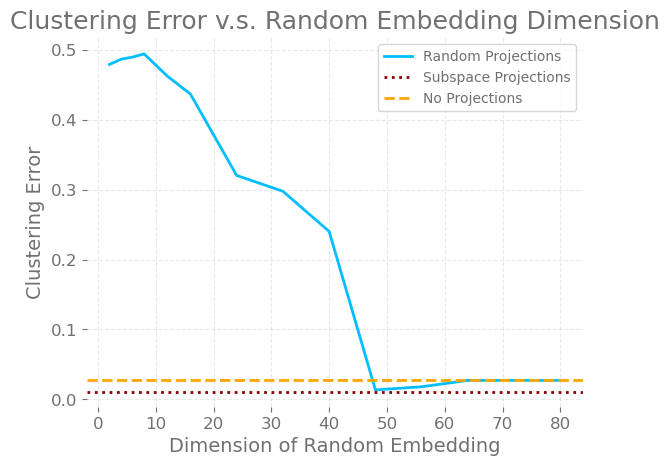

In [82]:
randAccs = []
dims = [2,4,6,8,12,16,24,32,40,48,56,64,72,80]
for dim in dims:
    randProjs = np.linalg.qr(np.random.normal(size=(nStates,nActions,nStates,dim)))[0]
    statRandProjs = computeStat(hs, 
                            randProjs, numpy=False, smalldata=False, device=device, proj=True)
    clusterRands = sklearn.cluster.spectral_clustering((statRandProjs < 0.0001).astype(int), n_clusters=2,
                                                         assign_labels='kmeans')
    randAccs.append(np.max([np.mean(clusterRands == confounders[sz:, 0]), 
                        np.mean(clusterRands != confounders[sz:, 0])]))
        
#clusterDiagnostics(statRandProjs, K=K, labels=confounders[sz:, 0],
#               lo=0, hi=0.0005, step=0.000025) #0,0.01, 0.0001
#plt.show()
plt.plot(dims, 1-np.array(randAccs), label='Random Projections')
plt.axhline(1-clusterAccs[-1], color='darkred', linestyle='dotted', label='Subspace Projections')
plt.axhline(1-clusterAccsNoProjs[-1], color='orange', linestyle='dashed', label='No Projections')
plt.xlabel('Dimension of Random Embedding')
plt.ylabel('Clustering Error')
plt.title('Clustering Error v.s. Random Embedding Dimension')
plt.legend()
plt.savefig('figs/jlRandEmbedding.png')

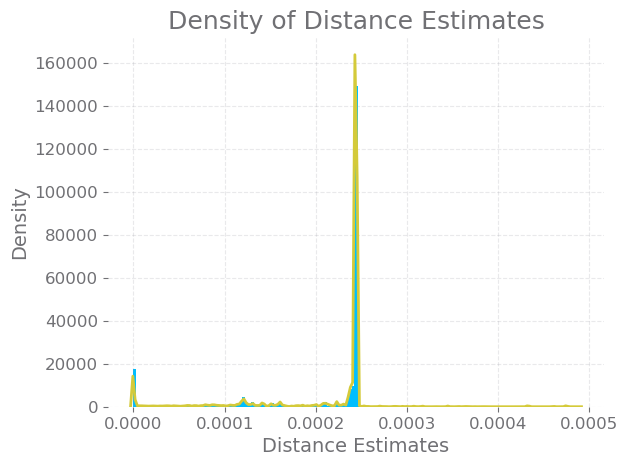

In [83]:
import seaborn as sns
#plt.figure(figsize=(16,9))
plt.hist(statmns.flatten(), bins=200, density=True)#[1]
#plt.hist(statmns.flatten(), bins=onehotsaclust.shape[0], density=True)[2]
sns.kdeplot(statmns.flatten(), bw_adjust=0.2)
#plt.title('')
plt.xlabel('Distance Estimates')
plt.ylabel('Density')
plt.title('Density of Distance Estimates')
plt.savefig('figs/distDens.png')
plt.show()

100%|██████████| 20/20 [00:01<00:00, 16.92it/s]


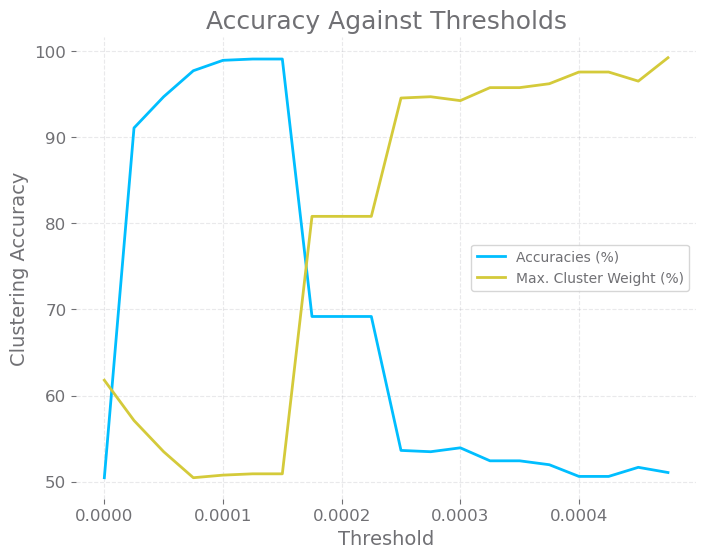

In [84]:
clusterDiagnostics(statmns, K=K, labels=confounders[sz:, 0],
                           lo=0, hi=0.0005, step=0.000025, figsize=(8,6))
plt.ylabel('Clustering Accuracy')
plt.title('Accuracy Against Thresholds')
plt.savefig('figs/clustAccs.png')

0.7495631720430106
0.7595766129032258
0.9183467741935484


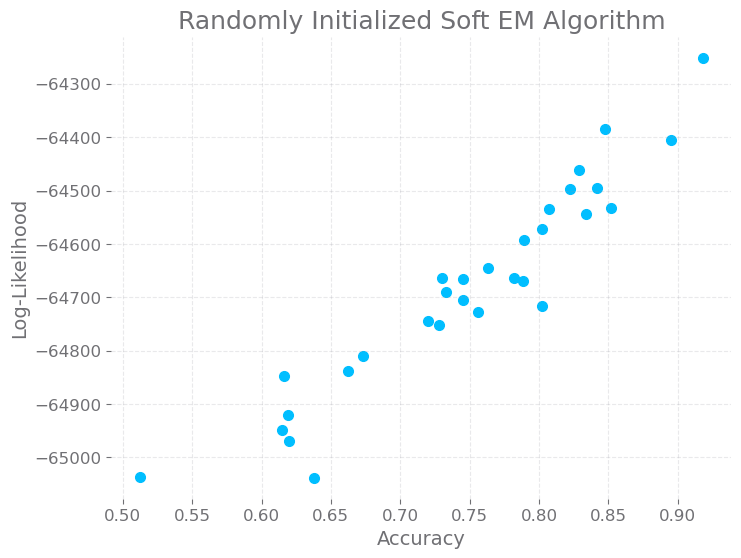

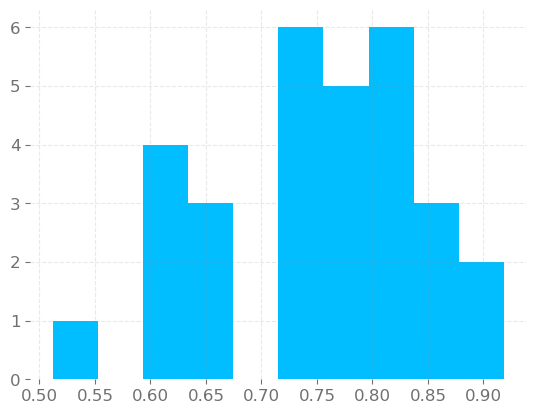

In [85]:
plt.figure(figsize=(8,6))
plt.scatter([max(np.mean(i == labels), np.mean(i != labels)) for i in np.array(labelsemsoft).argmax(axis=1)], 
            logliksemsoft)
print(np.mean([max(np.mean(i == labels), np.mean(i != labels)) for i in np.array(labelsemsoft).argmax(axis=1)]))
print(np.median([max(np.mean(i == labels), np.mean(i != labels)) for i in np.array(labelsemsoft).argmax(axis=1)]))
print(np.max([max(np.mean(i == labels), np.mean(i != labels)) for i in np.array(labelsemsoft).argmax(axis=1)]))
plt.ticklabel_format(style='plain',useOffset=False)
plt.xlabel('Accuracy')
plt.ylabel('Log-Likelihood')
plt.title('Randomly Initialized Soft EM Algorithm')
plt.savefig('figs/softEM.png')
plt.show()
plt.hist([max(np.mean(i == labels), np.mean(i != labels)) for i in np.array(labelsemsoft).argmax(axis=1)])
plt.show()

0.9852970795568979


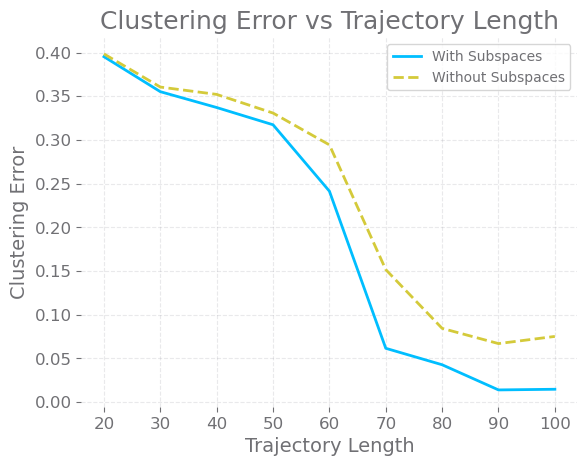

In [86]:
#plt.figure(figsize=(16,9))
print(np.mean(np.array(clusterAccsTrials),0)[-1])
plt.plot(horizons, 1-np.mean(np.array(clusterAccsTrials),0), label='With Subspaces')
plt.plot(horizons, 1-np.mean(np.array(clusterAccsNoProjsTrials),0), label='Without Subspaces',
        linestyle='--')
plt.ylabel("Clustering Error")
plt.xlabel("Trajectory Length")
plt.title("Clustering Error vs Trajectory Length")
plt.legend()
plt.savefig('figs/clust.png')

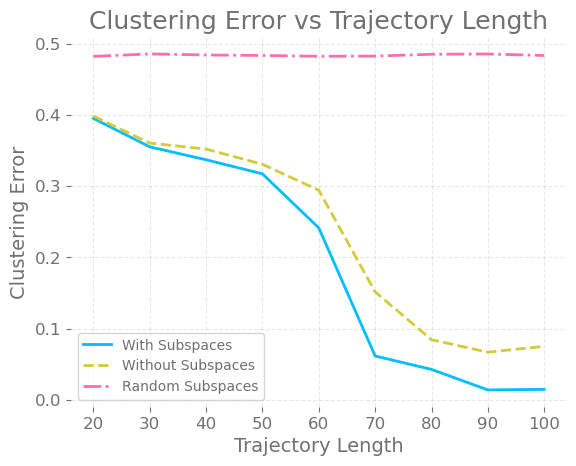

In [87]:
#plt.figure(figsize=(16,9))
plt.plot(horizons, 1-np.mean(np.array(clusterAccsTrials),0), label='With Subspaces')
plt.plot(horizons, 1-np.mean(np.array(clusterAccsNoProjsTrials),0), label='Without Subspaces',
        linestyle='--')
plt.plot(horizons, 1-np.mean(np.array(clusterAccsRandProjsTrials),0), label='Random Subspaces',
        linestyle='dashdot')
plt.ylabel("Clustering Error")
plt.xlabel("Trajectory Length")
plt.title("Clustering Error vs Trajectory Length")
plt.legend()
plt.savefig('figs/clustRand.png')

In [28]:
np.mean(np.array(clusterAccsTrials),0)

array([0.60473313, 0.64476334, 0.66289023, 0.6826284 , 0.75861027,
       0.93841893, 0.95725076, 0.98605237, 0.98529708])

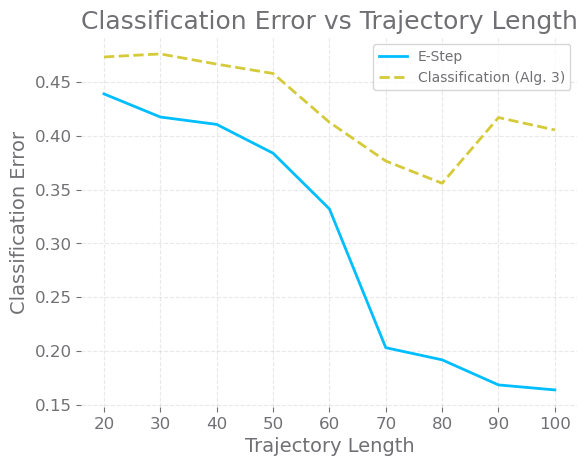

In [88]:
#plt.figure(figsize=(16,9))
plt.plot(horizons, 1-np.mean(np.array(classAccsTrials),0), label='E-Step')
plt.plot(horizons, 1-np.mean(np.array(classProjAccsTrials),0), label='Classification (Alg. 3)',
        linestyle='--')
plt.ylabel("Classification Error")
plt.xlabel("Trajectory Length")
plt.title("Classification Error vs Trajectory Length")
plt.legend()

0.964885752688172


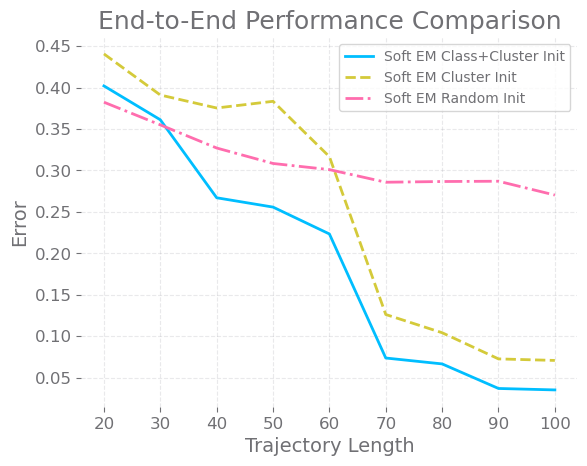

In [96]:
#plt.figure(figsize=(16,9))
'''
plt.plot(horizons, 1-np.median(np.array(hardClustEMAccsTrials),0),
         label='Hard EM Cluster Init')
plt.plot(horizons, 1-np.median(np.array(hardEMAccsTrials),0),
        label='Hard EM')
'''  
print(np.mean(np.array(softClassEMAccsTrials),0)[-1])
plt.plot(horizons, 1-np.mean(np.array(softClassEMAccsTrials),0),
         label='Soft EM Class+Cluster Init')
plt.plot(horizons, 1-np.mean(np.array(softClustEMAccsTrials),0),
         label='Soft EM Cluster Init',
        linestyle='--')
plt.plot(horizons, 1-np.mean(np.array(softEMAccsTrials),0),
        label='Soft EM Random Init',
        linestyle='dashdot')
#plt.plot(horizons, 1-np.mean(np.array(hardClustEMAccsTrials),0),
#         label='Hard EM Cluster Init',
#        linestyle='--')
#plt.plot(horizons, 1-np.mean(np.array(hardEMAccsTrials),0),
#        label='Hard EM Random Init',
#        linestyle='dashdot')
plt.ylabel("Error")
plt.xlabel("Trajectory Length")
plt.title("End-to-End Performance Comparison")
plt.legend()
plt.savefig('figs/emClust.png')

0.964885752688172


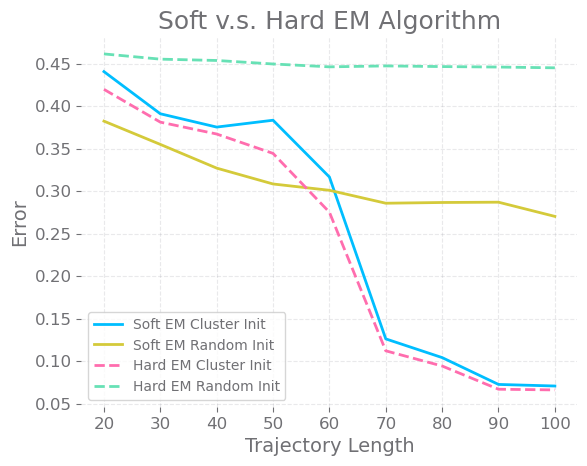

In [90]:
#plt.figure(figsize=(16,9))
'''
plt.plot(horizons, 1-np.median(np.array(hardClustEMAccsTrials),0),
         label='Hard EM Cluster Init')
plt.plot(horizons, 1-np.median(np.array(hardEMAccsTrials),0),
        label='Hard EM')
'''  
print(np.mean(np.array(softClassEMAccsTrials),0)[-1])
plt.plot(horizons, 1-np.mean(np.array(softClustEMAccsTrials),0),
         label='Soft EM Cluster Init')
plt.plot(horizons, 1-np.mean(np.array(softEMAccsTrials),0),
        label='Soft EM Random Init')
plt.plot(horizons, 1-np.mean(np.array(hardClustEMAccsTrials),0),
         label='Hard EM Cluster Init',
        linestyle='--')
plt.plot(horizons, 1-np.mean(np.array(hardEMAccsTrials),0),
        label='Hard EM Random Init',
        linestyle='--')
plt.ylabel("Error")
plt.xlabel("Trajectory Length")
plt.title("Soft v.s. Hard EM Algorithm")
plt.legend()
plt.savefig('figs/emSoftHard.png')

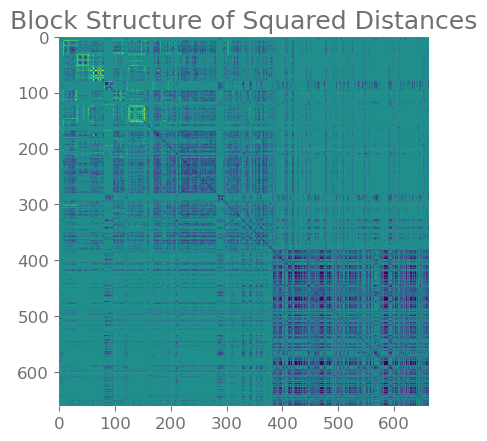

In [91]:
from scipy.cluster.hierarchy import linkage

m = 1-statmns #need similarity matrix
# shuffle
perm = np.random.permutation(len(m))
m = m[perm][:, perm]

# reorder
y = m[np.triu_indices(len(m), k=1)]
Z = linkage(y, method='single', optimal_ordering=True)
perm = np.ravel(Z[:, :2]).astype(np.int32)
perm = perm[perm < len(m)]
m = m[perm][:, perm]

#plt.figure(figsize=(16,9))
plt.imshow(1-m)
plt.title('Block Structure of Squared Distances')
plt.savefig('figs/blocks.png')

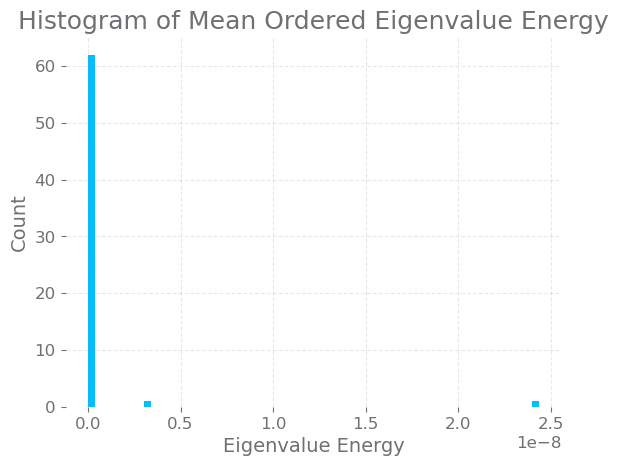

In [92]:
plt.hist((np.sort(vals, axis=-1)**2).mean((0,1)), bins=nStates)
plt.title('Histogram of Mean Ordered Eigenvalue Energy')
plt.ylabel('Count')
plt.xlabel('Eigenvalue Energy')
plt.savefig('figs/eigEnergy.png')
plt.show()

In [93]:
d_min = np.minimum(getN_sa(dataset[dataset[:,:,2]==0], nStates, nActions, burnin=0, reshape=False)/len(dataset[dataset[:,:,2]==0]),
           getN_sa(dataset[dataset[:,:,2]==1], nStates, nActions, burnin=0, reshape=False)/len(dataset[dataset[:,:,2]==1]))

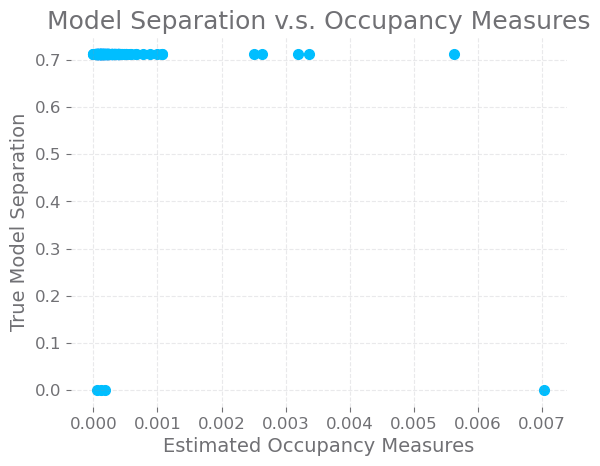

In [94]:
plt.scatter(d_min.flatten(), np.linalg.norm((P[0])-(P[1]), axis=-1).flatten())
plt.xlabel('Estimated Occupancy Measures')
plt.ylabel('True Model Separation')
plt.title('Model Separation v.s. Occupancy Measures')
plt.savefig('figs/trueModelSep.png')

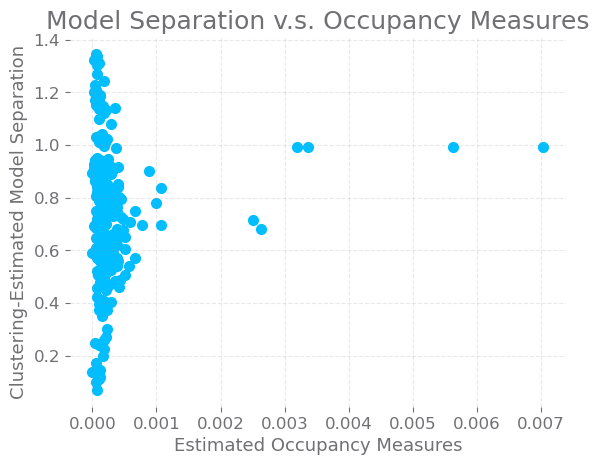

In [95]:
plt.scatter(d_min.flatten(), np.linalg.norm((modelEstims[-1][0])-(modelEstims[-1][1]), axis=-1).flatten())
plt.xlabel('Estimated Occupancy Measures', fontsize=13)
plt.ylabel('Clustering-Estimated Model Separation', fontsize=13)
plt.title('Model Separation v.s. Occupancy Measures')
plt.savefig('figs/clustModelSep.png')